In [12]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

print("Path to dataset files:", path)



Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals
Path to dataset files: /kaggle/input/animal-image-dataset-90-different-animals


In [2]:
# Importing necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report

In [3]:
# Ensuring the GPU is being used
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    print('GPU is being used.')
else:
    print('GPU is not being used.')


GPU is not being used.


In [4]:
import kagglehub
import os

# Download dataset and get actual path
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

# Set dataset path correctly
dataset_path = os.path.join(path, "animals", "animals")

# Now list the class folders
classes = sorted(os.listdir(dataset_path))
num_classes = len(classes)

print(f'Number of Classes: {num_classes}')
print(f'Classes: {classes}')



Number of Classes: 90
Classes: ['antelope', 'badger', 'bat', 'bear', 'bee', 'beetle', 'bison', 'boar', 'butterfly', 'cat', 'caterpillar', 'chimpanzee', 'cockroach', 'cow', 'coyote', 'crab', 'crow', 'deer', 'dog', 'dolphin', 'donkey', 'dragonfly', 'duck', 'eagle', 'elephant', 'flamingo', 'fly', 'fox', 'goat', 'goldfish', 'goose', 'gorilla', 'grasshopper', 'hamster', 'hare', 'hedgehog', 'hippopotamus', 'hornbill', 'horse', 'hummingbird', 'hyena', 'jellyfish', 'kangaroo', 'koala', 'ladybugs', 'leopard', 'lion', 'lizard', 'lobster', 'mosquito', 'moth', 'mouse', 'octopus', 'okapi', 'orangutan', 'otter', 'owl', 'ox', 'oyster', 'panda', 'parrot', 'pelecaniformes', 'penguin', 'pig', 'pigeon', 'porcupine', 'possum', 'raccoon', 'rat', 'reindeer', 'rhinoceros', 'sandpiper', 'seahorse', 'seal', 'shark', 'sheep', 'snake', 'sparrow', 'squid', 'squirrel', 'starfish', 'swan', 'tiger', 'turkey', 'turtle', 'whale', 'wolf', 'wombat', 'woodpecker', 'zebra']


In [5]:
# Visualize some sample images form the dataset
plt.figure(figsize=(20,15))
for i, class_name in enumerate(classes[:14]):
  class_path = os.path.join(dataset_path, class_name)
  img_name = os.listdir(class_path)[0]
  img_path = os.path.join(class_path, img_name)
  img = plt.imread(img_path)

  plt.subplot(3, 7, i+1)
  plt.imshow(img)
  plt.title(f'{class_name} \n shape: {img.shape}')
  plt.axis('off')
plt.tight_layout()
plt.show()


Output hidden; open in https://colab.research.google.com to view.

In [6]:
# --- Data Preprocessing ---

# Set parameters
image_size = (224, 224)
batch_size = 32

# ImageDataGenerator for training and validation (with rescaling)
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2  # 80% train, 20% validation
)

# Training data generator
train_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Validation data generator
val_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True
)

Found 4320 images belonging to 90 classes.
Found 1080 images belonging to 90 classes.


In [7]:
# Map the classes - class_indices
class_indices = train_generator.class_indices
print(class_indices)
# Extract class names
class_names = list(class_indices.keys())
print("Class Names:", class_names)


{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

In [8]:
# Load MobileNetV2 as the base model
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze the base model weights, training
base_model.trainable = False

# Add custom layers on top of the base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x) # output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])
# Model summary
model.summary()


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 3,661,978 (13.97 MB)

 Trainable params: 1,403,994 (5.36 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import math

# Define image size and batch size
img_height = 224
img_width = 224
batch_size = 32

# Create ImageDataGenerator for validation
datagen = ImageDataGenerator(rescale=1./255)

# Create validation generator
validation_generator = datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 5400 images belonging to 90 classes.


In [13]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples / batch_size),
    validation_data=validation_generator,
    validation_steps=math.ceil(validation_generator.samples / batch_size),
    epochs=10,
    verbose=1
)

Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 531s 4s/step - accuracy: 0.5376 - loss: 2.4315 - val_accuracy: 0.8187 - val_loss: 1.1838
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 501s 3s/step - accuracy: 0.7264 - loss: 1.2934 - val_accuracy: 0.8689 - val_loss: 0.7280
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 479s 4s/step - accuracy: 0.7899 - loss: 0.9053 - val_accuracy: 0.8967 - val_loss: 0.5360
Epoch 4/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 501s 4s/step - accuracy: 0.8384 - loss: 0.6747 - val_accuracy: 0.9191 - val_loss: 0.4330
Epoch 5/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 492s 3s/step - accuracy: 0.8648 - loss: 0.5404 - val_accuracy: 0.9307 - val_loss: 0.3580
Epoch 6/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 471s 4s/step - accuracy: 0.8948 - loss: 0.4460 - val_accuracy: 0.9409 - val_loss: 0.3087
Epoch 7/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 500s 3s/step - accuracy: 0.9147 - loss: 0.3545 - val_accuracy: 0.9504 - val_loss: 0.2676
Epoch 8/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 470s 3s/step - accuracy: 0.9241 - loss: 0.3216 - val_accu

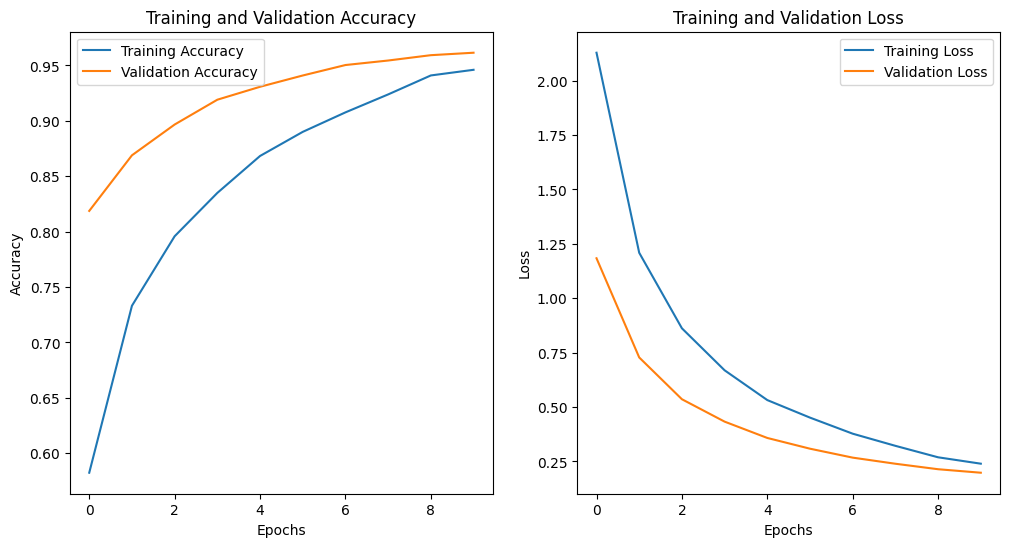

In [14]:
# Evaluate the model - plotting the training and validation acc/loss
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [15]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f'Validation Loss: {val_loss}')
print(f'Validation Accuracy: {val_accuracy}')

169/169 ━━━━━━━━━━━━━━━━━━━━ 263s 2s/step - accuracy: 0.9594 - loss: 0.2047
Validation Loss: 0.19827750325202942
Validation Accuracy: 0.9614814519882202


In [16]:
# Save the model
model.save('MCAR.keras')

In [17]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model = load_model('MCAR.keras')

def predict_animal(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0

    prediction = model.predict(img_array)
    predicted_class = class_names[np.argmax(prediction)]

    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()

In [18]:
os.listdir('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/cat')

['4815f8dfaa.jpg',
 '4c6ff6dae0.jpg',
 '1f016e1910.jpg',
 '8d88a86d91.jpg',
 '0d0d6d90d8.jpg',
 '4bd8b7789f.jpg',
 '6edc079fcf.jpg',
 '6fe978c917.jpg',
 '8af49688fa.jpg',
 '124eecb74f.jpg',
 '34fb30ecc5.jpg',
 '730d6a8791.jpg',
 '578d493138.jpg',
 '9293137b5d.jpg',
 '612c521481.jpg',
 '11883c3dd8.jpg',
 '6a5e9eac29.jpg',
 '057e6db146.jpg',
 '00357563a7.jpg',
 '67dc417509.jpg',
 '1a2dce7848.jpg',
 '68a2e3af59.jpg',
 '2d7dc1ddb5.jpg',
 '8aefee4c2c.jpg',
 '0c3d04bcf5.jpg',
 '71c2375c64.jpg',
 '83e8a824a2.jpg',
 '354bb2acdf.jpg',
 '9fd544a838.jpg',
 '6128bd1a84.jpg',
 '31ae8d36b6.jpg',
 '15b23c04b7.jpg',
 '5a5cdbdc6b.jpg',
 '5e07a0666d.jpg',
 '094ac674a9.jpg',
 '98470f6918.jpg',
 '636b432421.jpg',
 '5aaea25f27.jpg',
 '2a40de8365.jpg',
 '78359cbe21.jpg',
 '3321ec48a8.jpg',
 '72c56919f9.jpg',
 '84db062d1f.jpg',
 '9d21019336.jpg',
 '087d293433.jpg',
 '77dee19720.jpg',
 '0b54dde5f5.jpg',
 '76273ddb00.jpg',
 '6296ca5ccf.jpg',
 '66548aefad.jpg',
 '39ae72da61.jpg',
 '32cd00f171.jpg',
 '9e020b77ac

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


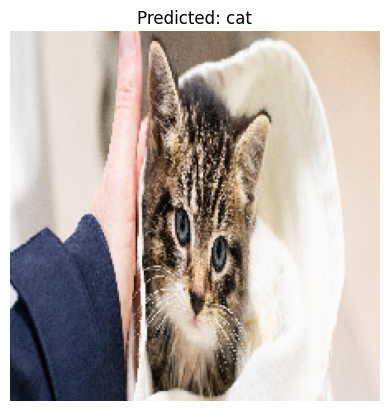

In [20]:
predict_animal('/kaggle/input/animal-image-dataset-90-different-animals/animals/animals/cat/7f923c6676.jpg')